In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from typing import List

import numpy as np
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, isnan, when
from pyspark.sql.types import IntegerType, DoubleType, BooleanType

In [2]:
spark = SparkSession.builder.appName("diabetes_indicators").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 23:26:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load the Dataset

In [3]:
df_male = spark.read.csv("./data/diabetes_large/male_data.csv", header=True, inferSchema=True)
df_male.show(5, truncate=False)

23/10/11 23:27:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+------+-----------+------+-----+-------+--------+-------------+-------------+--------+--------+--------+--------+--------+------+--------+------+---------------------+--------+--------+------+--------+--------+------+--------+-------+-------+--------+--------+--------+--------+--------+-------+--------+-------+------+--------+-------+-------+--------+--------+--------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---+-------+-----+--------+--------+--------+-------+--------+-------+--------+-------+--------+-------+-------+--------+--------+--------+-----+------+--------+--------+--------+--------+--------+--------+--------+-------+-------+--------+--------+--------+--------+------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+-------+--------+--------+---

In [5]:
df_female = spark.read.csv("./data/diabetes_large/female_data.csv", header=True, inferSchema=True)
df_female.show(5, truncate=False)

+------+------+-----------+------+-----+-------+--------+-------------+-------------+--------+--------+--------+--------+--------+------+--------+---------------------+--------+--------+--------+------+--------+--------+------+--------+-------+-------+--------+--------+--------+--------+--------+-------+--------+-------+------+--------+-------+-------+--------+--------+--------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---+-------+-----+--------+--------+--------+-------+--------+-------+--------+-------+--------+-------+-------+--------+--------+--------+-----+------+--------+--------+--------+--------+--------+--------+--------+-------+-------+--------+--------+--------+--------+------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+-------+--------+--------+-

In [6]:
print(f"Number of records in Male: {df_male.count()}")
print(f"Number of records in Female: {df_female.count()}")

Number of records in Male: 186938
Number of records in Female: 254518


In [7]:
def unionAll(dfs: List):
    """ Function to merge two sources of data """
    unioned_df = functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)
    return unioned_df

In [72]:
df = unionAll([df_male, df_female])

In [73]:
assert df.columns == df_male.columns and df.columns == df_female.columns, "There has been a join error"

# Data Exploration

In [74]:
print(f"Shape of the data: {df.count(), len(df.columns)}")

Shape of the data: (441456, 330)


In [75]:
df.columns[:30]

['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'DISPCODE',
 'SEQNO',
 '_PSU',
 'CTELENUM',
 'PVTRESD1',
 'COLGHOUS',
 'STATERES',
 'CELLFON3',
 'LADULT',
 'NUMADULT',
 'NUMMEN',
 'NUMWOMEN',
 'CTELNUM1',
 'CELLFON2',
 'CADULT',
 'PVTRESD2',
 'CCLGHOUS',
 'CSTATE',
 'LANDLINE',
 'HHADULT',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'POORHLTH']

## - Feature Selection

In [76]:
df = df.select("DIABETE3", "CHCKIDNY", "_RFHYPE5", "TOLDHI2", 
               "_BMI5", "SMOKE100", "CVDSTRK3", "_MICHD",
               "_TOTINDA", "_FRTLT1", "_VEGLT1", "_RFDRHV5", 
               "MEDCOST", "GENHLTH", "PHYSHLTH", "MENTHLTH", "SEX", "_AGEG5YR", 
               "_MRACE1", "EDUCA", "INCOME2")

df.show(5, truncate=False)

+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|DIABETE3|CHCKIDNY|_RFHYPE5|TOLDHI2|_BMI5 |SMOKE100|CVDSTRK3|_MICHD|_TOTINDA|_FRTLT1|_VEGLT1|_RFDRHV5|MEDCOST|GENHLTH|PHYSHLTH|MENTHLTH|SEX|_AGEG5YR|_MRACE1|EDUCA|INCOME2|
+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|3.0     |7.0     |2.0     |1.0    |3382.0|1.0     |2.0     |null  |1.0     |1.0    |1.0    |1.0     |1.0    |5.0    |8.0     |88.0    |1.0|13.0    |1.0    |3.0  |3.0    |
|3.0     |2.0     |2.0     |1.0    |2522.0|1.0     |2.0     |2.0   |1.0     |1.0    |1.0    |1.0     |2.0    |2.0    |2.0     |88.0    |1.0|10.0    |1.0    |6.0  |8.0    |
|3.0     |2.0     |2.0     |1.0    |2554.0|1.0     |2.0     |2.0   |9.0     |9.0    |9.0    |1.0     |1.0    |3.0    |88.0    |88.0    |1.0|

## - Data Stats

In [77]:
df.describe().toPandas()

,summary,DIABETE3,CHCKIDNY,_RFHYPE5,TOLDHI2,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,...,_RFDRHV5,MEDCOST,GENHLTH,PHYSHLTH,MENTHLTH,SEX,_AGEG5YR,_MRACE1,EDUCA,INCOME2
0,count,441449,441456,441456,382302,405058,427201,441456,437514,441456,...,441456,441455,441454,441455,441456,441456,441456,441456,441456,438155
1,mean,2.7578882271791305,1.9833097749266064,1.428427748178754,1.63087559050175,2804.268660290625,1.613987326808692,1.973879616541626,1.9117011112787248,1.931868634699721,...,1.5163096661954985,1.916066190211913,2.578789636066272,60.65511320519645,64.67917753977747,1.576542169548041,7.803597640534957,3.2072641441049616,4.920093961799138,20.25301320309023
2,stddev,0.7233186065267395,0.36807208809859604,0.6468486754195959,0.7402354553200333,665.7567782209281,0.7465300192132814,0.3486887819595295,0.2837294115374936,2.2097291018113263,...,1.8745809363748314,0.41541350189505793,1.117584903897917,37.05568366561998,35.843085038113024,0.4941071233231373,3.495618418010292,12.58662494429264,1.0761982009143163,31.853506675722013
3,min,1.0,1.0,1.0,1.0,1202.0,1.0,1.0,1.0,5.397605346934028E-79,...,5.397605346934028E-79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,max,9.0,9.0,9.0,9.0,15558.0,9.0,9.0,2.0,9.0,...,9.0,9.0,9.0,99.0,99.0,2.0,14.0,99.0,9.0,99.0


## - Missing Data Stats

In [78]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0---------
 DIABETE3 | 7     
 CHCKIDNY | 0     
 _RFHYPE5 | 0     
 TOLDHI2  | 59154 
 _BMI5    | 36398 
 SMOKE100 | 14255 
 CVDSTRK3 | 0     
 _MICHD   | 3942  
 _TOTINDA | 0     
 _FRTLT1  | 0     
 _VEGLT1  | 0     
 _RFDRHV5 | 0     
 MEDCOST  | 1     
 GENHLTH  | 2     
 PHYSHLTH | 1     
 MENTHLTH | 0     
 SEX      | 0     
 _AGEG5YR | 0     
 _MRACE1  | 0     
 EDUCA    | 0     
 INCOME2  | 3301  



# Data Visualization

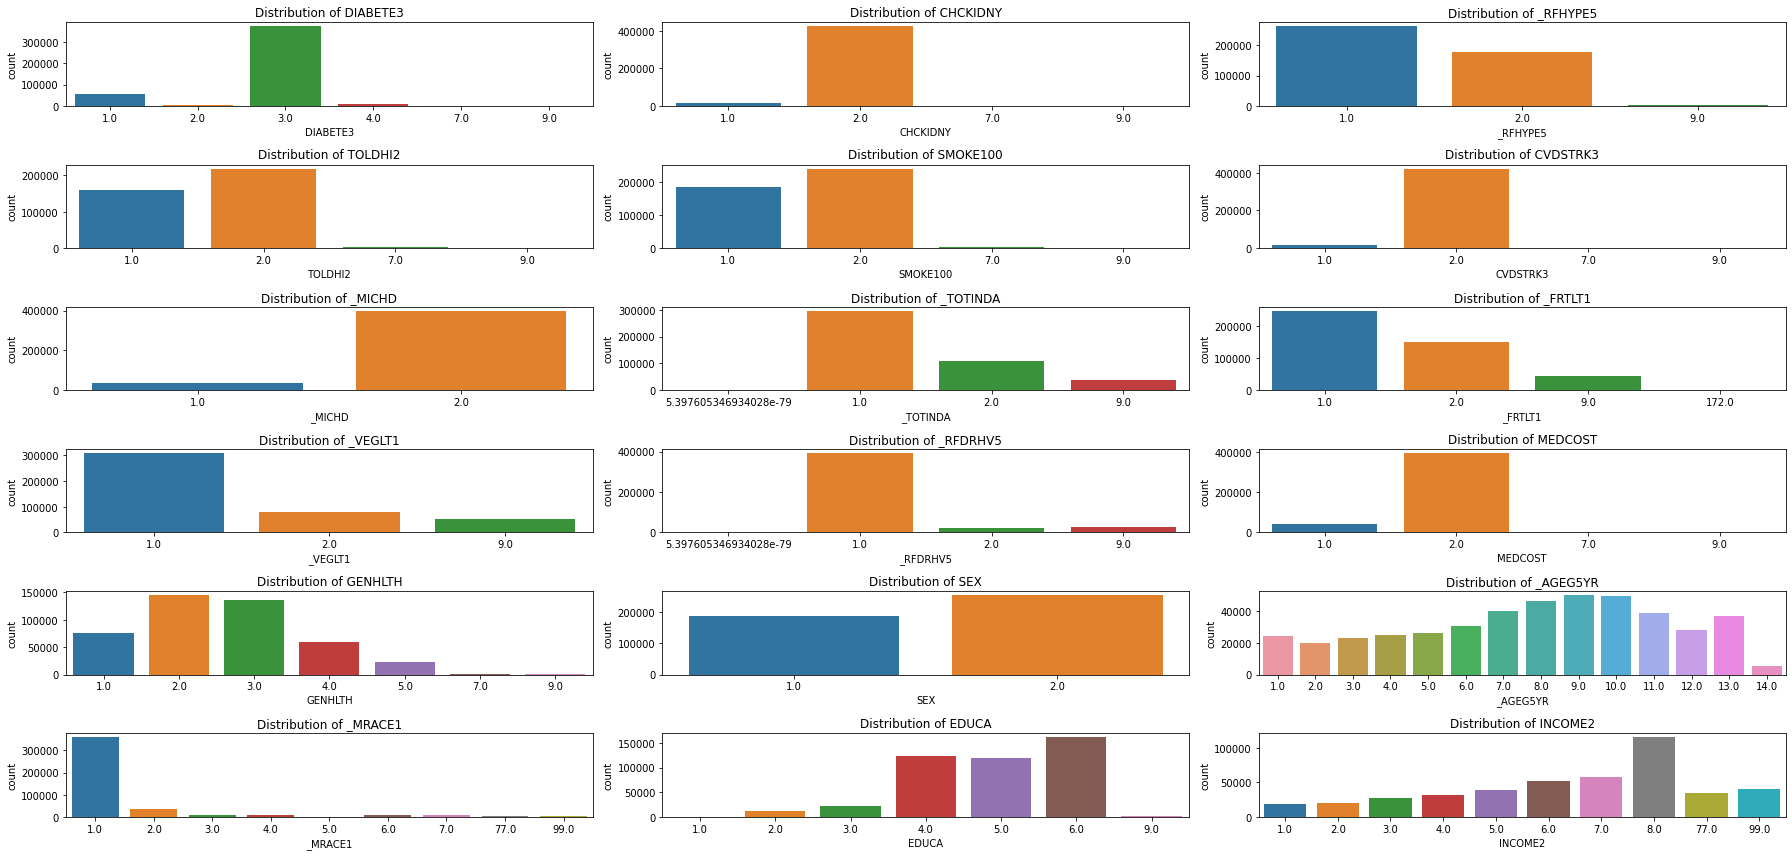

In [79]:
fig, axs = plt.subplots(6, 3, figsize=(25, 12))
axs = axs.flatten()

cat_cols = list(filter(lambda x: x not in ["_BMI5", "PHYSHLTH", "MENTHLTH"], df.columns))


for i, cols in enumerate(cat_cols):
    axs[i].set_title(f"Distribution of {cols}")
    sns.countplot(x=cols, data=df.select(cols).toPandas(), ax=axs[i])

plt.tight_layout()
plt.show()
    

In [80]:
df.select("_BMI5").describe().show()

+-------+-----------------+
|summary|            _BMI5|
+-------+-----------------+
|  count|           405058|
|   mean|2804.268660290625|
| stddev|665.7567782209281|
|    min|           1202.0|
|    max|          15558.0|
+-------+-----------------+



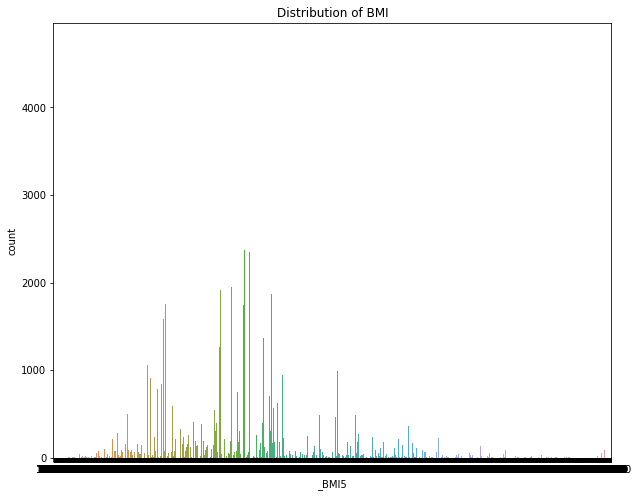

In [81]:
plt.figure(figsize=(10, 8))
plt.title("Distribution of BMI")
sns.countplot(x="_BMI5", data=df.select("_BMI5").toPandas())
plt.show()

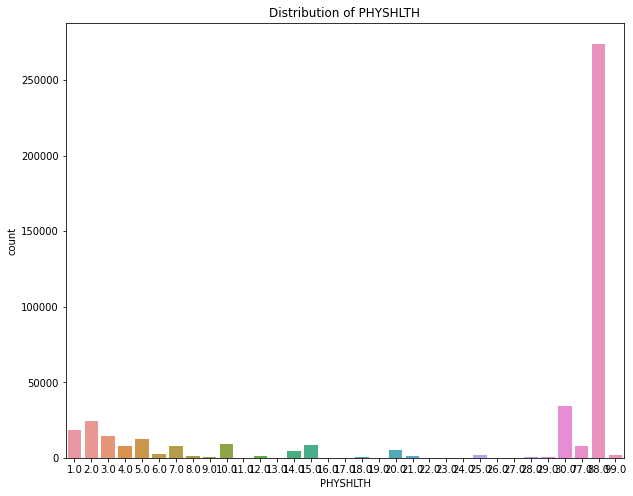

In [82]:
plt.figure(figsize=(10, 8))
plt.title("Distribution of PHYSHLTH")
sns.countplot(x="PHYSHLTH", data=df.select("PHYSHLTH").toPandas())
plt.show()

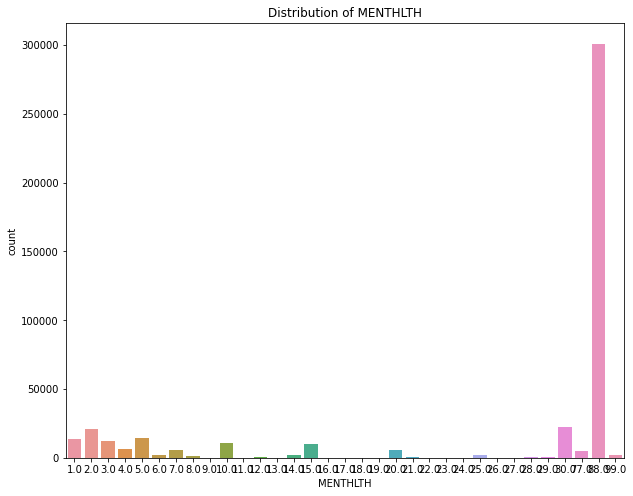

In [83]:
plt.figure(figsize=(10, 8))
plt.title("Distribution of MENTHLTH")
sns.countplot(x="MENTHLTH", data=df.select("MENTHLTH").toPandas())
plt.show()

In [84]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "CHCKIDNY").show()

+-----------------+----+------+---+---+
|DIABETE3_CHCKIDNY| 1.0|   2.0|7.0|9.0|
+-----------------+----+------+---+---+
|              1.0|5692| 51131|408| 25|
|              9.0|   2|    78|  1|112|
|              2.0|  79|  3519| 10|  0|
|              7.0|  34|   500| 63|  1|
|              3.0|9498|361706|839| 61|
|              4.0| 351|  7282| 54|  3|
+-----------------+----+------+---+---+



In [85]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_RFHYPE5").show()

+-----------------+------+------+----+
|DIABETE3__RFHYPE5|   1.0|   2.0| 9.0|
+-----------------+------+------+----+
|              1.0| 14163| 42908| 185|
|              9.0|    61|    41|  91|
|              2.0|  2535|  1070|   3|
|              7.0|   261|   319|  18|
|              3.0|241966|129095|1043|
|              4.0|  2911|  4751|  28|
+-----------------+------+------+----+



In [86]:
df.na.drop(subset=["DIABETE3", "TOLDHI2"]).crosstab("DIABETE3", "TOLDHI2").show()

+----------------+------+------+----+---+
|DIABETE3_TOLDHI2|   1.0|   2.0| 7.0|9.0|
+----------------+------+------+----+---+
|             1.0| 36204| 18532| 508| 53|
|             9.0|    36|    51|   3| 52|
|             2.0|  1021|  1936|  20|  0|
|             7.0|   241|   172|  24|  6|
|             3.0|118049|195374|2384|399|
|             4.0|  4415|  2705|  98| 14|
+----------------+------+------+----+---+



In [87]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_MRACE1").show()

+----------------+------+-----+----+----+----+----+----+----+----+
|DIABETE3__MRACE1|   1.0|  2.0| 3.0| 4.0| 5.0| 6.0| 7.0|77.0|99.0|
+----------------+------+-----+----+----+----+----+----+----+----+
|             1.0| 43725| 7255|1501| 925| 230|1213|1222| 494| 691|
|             9.0|   119|   17|   1|   5|   0|   3|   3|   0|  45|
|             2.0|  2802|  301|  84| 122|  28|  96|  77|  62|  36|
|             7.0|   385|   63|  22|  27|   8|  25|  19|  28|  21|
|             3.0|306358|27474|6118|8799|1437|7120|7509|2825|4464|
|             4.0|  5779|  796| 216| 239|  40| 216| 255|  66|  83|
+----------------+------+-----+----+----+----+----+----+----+----+



In [88]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_AGEG5YR").show()

+-----------------+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+
|DIABETE3__AGEG5YR|  1.0| 10.0| 11.0| 12.0| 13.0|14.0|  2.0|  3.0|  4.0|  5.0|  6.0|  7.0|  8.0|  9.0|
+-----------------+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+
|              1.0|  228| 9997| 8391| 6119| 6618| 562|  281|  520|  980| 1583| 2560| 4509| 6348| 8560|
|              9.0|    3|   23|    9|   10|   11|  80|    3|    1|    4|    7|   11|    5|   17|    9|
|              2.0|  103|  189|  136|  104|  159|  42|  260|  438|  521|  439|  368|  352|  269|  228|
|              7.0|   39|   53|   55|   47|   63|  22|   35|   26|   34|   36|   33|   52|   48|   55|
|              3.0|23715|37873|28806|21215|29032|4566|19062|21782|22778|23609|26824|34299|38685|39858|
|              4.0|  103| 1128|  962|  736|  876|  64|  105|  150|  228|  268|  480|  664|  842| 1084|
+-----------------+-----+-----+-----+-----+-----+----+-----+-----+-----+-

In [89]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_FRTLT1").show()

+----------------+------+-----+------+-----+
|DIABETE3__FRTLT1|   1.0|172.0|   2.0|  9.0|
+----------------+------+-----+------+-----+
|             1.0| 30352|    1| 21322| 5581|
|             9.0|    75|    0|    45|   73|
|             2.0|  2207|    0|  1093|  308|
|             7.0|   260|    0|   231|  107|
|             3.0|210700|    0|124412|36992|
|             4.0|  4220|    0|  2821|  649|
+----------------+------+-----+------+-----+



In [90]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_VEGLT1").show()

+----------------+------+-----+-----+
|DIABETE3__VEGLT1|   1.0|  2.0|  9.0|
+----------------+------+-----+-----+
|             1.0| 37622|12846| 6788|
|             9.0|   101|   24|   68|
|             2.0|  2742|  502|  364|
|             7.0|   314|  157|  127|
|             3.0|263541|65597|42966|
|             4.0|  5236| 1651|  803|
+----------------+------+-----+-----+



In [91]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_RFDRHV5").show()

+-----------------+------+-----+---------------------+-----+
|DIABETE3__RFDRHV5|   1.0|  2.0|5.397605346934028E-79|  9.0|
+-----------------+------+-----+---------------------+-----+
|              1.0| 53215| 1165|                    1| 2875|
|              9.0|   126|    4|                    0|   63|
|              2.0|  3261|  166|                    0|  181|
|              7.0|   507|   17|                    0|   74|
|              3.0|329532|20412|                    0|22160|
|              4.0|  7010|  301|                    0|  379|
+-----------------+------+-----+---------------------+-----+



# Data Manipulation

## - Drop missing values from target variable

In [100]:
df_new = df.na.drop(subset=["DIABETE3"])
assert df_new.count() < df.count() and len(df_new.columns) == len(df.columns), "There has been a problem with the missing value dropping"

print(f"Shape of the new dataframe: ({df_new.count()}, {len(df_new.columns)})")

Shape of the new dataframe: (441449, 21)


## - Remove uncessary values from each predictor variables

In [101]:
df_new = df_new.filter((df_new.DIABETE3 != 7) & (df_new.DIABETE3 != 9)& 
                       (df_new.CHCKIDNY != 9) & (df_new.CHCKIDNY != 7) & (df_new._RFHYPE5 != 9)& (df_new.TOLDHI2 != 7) &
                      (df_new.TOLDHI2 != 9) & (df_new.SMOKE100 != 9) & (df_new.SMOKE100 != 7) &
                      (df_new.CVDSTRK3 != 9) & (df_new.CVDSTRK3 != 7) & (df_new._TOTINDA != 9) &
                      (df_new._FRTLT1 != 9) & (df_new._VEGLT1 != 9) &
                      (df_new._RFDRHV5 != 9) & (df_new.MEDCOST != 7) &
                       (df_new.MEDCOST != 9) &
                      (df_new.GENHLTH != 7) & (df_new.GENHLTH != 9) & (df_new.PHYSHLTH != 77) &
                       (df_new.PHYSHLTH != 99) &
                     (df_new.MENTHLTH != 77) & (df_new.MENTHLTH != 99) & (df_new._AGEG5YR != 14) &
                      (df_new._MRACE1 != 77) & (df_new._MRACE1 != 99) & (df_new.EDUCA != 9) &
                       (df_new.INCOME2 != 77) & (df_new.INCOME2 != 99))

print(f"Shape of the new dataframe after filtering: ({df_new.count()}, {len(df_new.columns)})")

Shape of the new dataframe after filtering: (264942, 21)


## - Impute Missing Values

In [102]:
from pyspark.ml.feature import Imputer

imputer_real = Imputer(
    inputCols=["_BMI5", "PHYSHLTH"],
    outputCols=["_BMI5", "PHYSHLTH"]
).setStrategy("mean")

imputer_cat = Imputer(
    inputCols = ["TOLDHI2", "SMOKE100", "_MICHD", "MEDCOST", "GENHLTH", "INCOME2"],
    outputCols = ["TOLDHI2", "SMOKE100", "_MICHD", "MEDCOST", "GENHLTH", "INCOME2"],
).setStrategy("mode")

In [103]:
model_real = imputer_real.fit(df_new)
df_imputed = model_real.transform(df_new)
model_cat = imputer_cat.fit(df_imputed)
df_imputed_final = model_cat.transform(df_imputed)


assert df_imputed_final.count() == df_new.count() and len(df_imputed_final.columns) == len(df_new.columns), "There has been some problem with imputation of the data"

In [104]:
df_imputed_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0-------
 DIABETE3 | 0   
 CHCKIDNY | 0   
 _RFHYPE5 | 0   
 TOLDHI2  | 0   
 _BMI5    | 0   
 SMOKE100 | 0   
 CVDSTRK3 | 0   
 _MICHD   | 0   
 _TOTINDA | 0   
 _FRTLT1  | 0   
 _VEGLT1  | 0   
 _RFDRHV5 | 0   
 MEDCOST  | 0   
 GENHLTH  | 0   
 PHYSHLTH | 0   
 MENTHLTH | 0   
 SEX      | 0   
 _AGEG5YR | 0   
 _MRACE1  | 0   
 EDUCA    | 0   
 INCOME2  | 0   



In [105]:
df_imputed_final.show(5)

+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|DIABETE3|CHCKIDNY|_RFHYPE5|TOLDHI2| _BMI5|SMOKE100|CVDSTRK3|_MICHD|_TOTINDA|_FRTLT1|_VEGLT1|_RFDRHV5|MEDCOST|GENHLTH|PHYSHLTH|MENTHLTH|SEX|_AGEG5YR|_MRACE1|EDUCA|INCOME2|
+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|     3.0|     2.0|     2.0|    1.0|2522.0|     1.0|     2.0|   2.0|     1.0|    1.0|    1.0|     1.0|    2.0|    2.0|     2.0|    88.0|1.0|    10.0|    1.0|  6.0|    8.0|
|     3.0|     2.0|     1.0|    2.0|2407.0|     2.0|     2.0|   2.0|     2.0|    2.0|    1.0|     1.0|    2.0|    2.0|    88.0|    88.0|1.0|     8.0|    1.0|  4.0|    3.0|
|     1.0|     2.0|     1.0|    2.0|2468.0|     1.0|     2.0|   2.0|     1.0|    1.0|    1.0|     1.0|    2.0|    3.0|    88.0|    88.0|1.0|

## - Data Transformation

In [110]:
import pyspark.sql.functions as F

target_changes = {1:2, 4: 1, 2:0, 3:0}
map_col = F.create_map([F.lit(x) for i in target_changes.items() for x in i])
df_final = df_imputed_final.withColumn("DIABETE3", map_col[F.col("DIABETE3")])

In [111]:
def transform_data(df: pyspark.sql.DataFrame, map_dict: dict, colName: str) -> pyspark.sql.DataFrame:
    """ Function to transform predictor variable based on map_dict """
    map_col = F.create_map([F.lit(x) for i in map_dict.items() for x in i])
    new_df = df.withColumn(colName, map_col[F.col(colName)])
    
    return new_df

In [113]:
df_final = transform_data(df_final, {1:0, 2:1}, "_RFHYPE5")
df_final = transform_data(df_final, {1:1, 2:0}, "CHCKIDNY")
df_final = transform_data(df_final, {1:1, 2:0}, "TOLDHI2")
df_final = transform_data(df_final, {1:1, 2:0}, "SMOKE100")
df_final = transform_data(df_final, {1:1, 2:0}, "CVDSTRK3")
df_final = transform_data(df_final, {1:1, 2:0}, "_MICHD")
df_final = transform_data(df_final, {1:1, 2:0}, "_TOTINDA")
df_final = transform_data(df_final, {1:1, 2:0}, "_FRTLT1")
df_final = transform_data(df_final, {1:1, 2:0}, "_VEGLT1")
df_final = transform_data(df_final, {1:0, 2:1}, "_RFDRHV5")
df_final = transform_data(df_final, {1:1, 2:0}, "MEDCOST")
df_final = transform_data(df_final, {1:0, 2:1}, "SEX")

In [115]:
df_final.toPandas().to_csv("./data/diabetes_large/final_diabetes_dataset.csv", index=False)